# Прогнозирование оттока клиентов в компании Телеком

Оператор связи «ТелеДом» хочет бороться с оттоком клиентов. Для этого его сотрудники начнут предлагать промокоды и специальные условия всем, кто планирует отказаться от услуг связи. Чтобы заранее находить таких пользователей, «ТелеДому» нужна модель, которая будет предсказывать, разорвёт ли абонент договор. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и услугах. 

**Цель проекта:**  Обучить модель для прогноза оттока клиентов с целью улучшения реакции оператора связи на потенциальные угрозы ухода абонентов.  

**Содержание проекта:**  
1. [Загрузка данных и их первичный осмотр](#loading)
2. [Объединение данных](#merge)  
3. [Предобработка данных объединённого датафрейма, генерация новых признаков](#preprocessing)
4. [Исследовательский анализ и визуализация данных](#eda)   
5. [Обучение моделей машинного обучения, подбор гиперпараметров](#training)  
6. [Проверка лучшей модели на тестовой выборке](#testing)  
7. [Анализ работы лучшей модели](#results)
7. [Составление рекомендаций на основании полученных результатов](#conclusion)
  
**Описание предоставленных данных:**  
  
Данные состоят из нескольких файлов, полученных из разных источников:  

- contract_new.csv — информация о договоре
- personal_new.csv — персональные данные клиента
- internet_new.csv — информация об интернет-услугах
- phone_new.csv — информация об услугах телефонии  

Файл contract_new.csv  
- customerID — идентификатор абонента
- BeginDate — дата начала действия договора
- EndDate — дата окончания действия договора
- Type — тип оплаты: раз в год-два или ежемесячно
- PaperlessBilling — электронный расчётный лист
- PaymentMethod — тип платежа
- MonthlyCharges — расходы за месяц
- TotalCharges — общие расходы абонента  

Файл personal_new.csv
- customerID — идентификатор пользователя
- gender — пол
- SeniorCitizen — является ли абонент пенсионером
- Partner — есть ли у абонента супруг или супруга
- Dependents — есть ли у абонента дети

Файл internet_new.csv  
- customerID — идентификатор пользователя
- InternetService — тип подключения
- OnlineSecurity — блокировка опасных сайтов
- OnlineBackup — облачное хранилище файлов для резервного копирования данных
- DeviceProtection — антивирус
- TechSupport — выделенная линия технической поддержки
- StreamingTV — стриминговое телевидение
- StreamingMovies — каталог фильмов  

Файл phone_new.csv  
- customerID — идентификатор пользователя
- MultipleLines — подключение телефона к нескольким линиям одновременно  

Информация о договорах актуальна на 1 февраля 2020 года  

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import phik

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score, roc_curve, confusion_matrix


from sklearn.linear_model import LogisticRegression
import lightgbm as lgb
import xgboost as xgb

In [3]:
pd.set_option('display.max_columns', None)

<a id='loading'></a>
## Загрузка и первичный осмотр данных

In [4]:
try:
    # Попробуем загрузить данные через платформу
    contract_data = pd.read_csv('/datasets/contract_new.csv')
    personal_data = pd.read_csv('/datasets/personal_new.csv')
    internet_data = pd.read_csv('/datasets/internet_new.csv')
    phone_data = pd.read_csv('/datasets/phone_new.csv')
except FileNotFoundError:
    # Если файлы на платформе не найдены, загрузим локальные данные
    contract_data = pd.read_csv('contract_new.csv')
    personal_data = pd.read_csv('personal_new.csv')
    internet_data = pd.read_csv('internet_new.csv')
    phone_data = pd.read_csv('phone_new.csv')

In [5]:
# Выполним первичный осмотр данных
print("ИНФОРМАЦИЯ О ДОГОВОРЕ:")
display(contract_data.head())
print(contract_data.info())
print('Duplicated', contract_data['customerID'].duplicated().sum())
print('\n')

print("ПЕРСОНАЛЬНЫЕ ДАННЫЕ КЛИЕНТА:")
display(personal_data.head())
print(personal_data.info())
print('Duplicated', personal_data['customerID'].duplicated().sum())
print('\n')

print("ИНФОРМАЦИЯ ОБ ИНТЕРНЕТ-УСЛУГАХ:")
display(internet_data.head())
print(internet_data.info())
print('Duplicated', internet_data['customerID'].duplicated().sum())
print('\n')

print("ИНФОРМАЦИЯ ОБ УСЛУГАХ ТЕЛЕФОНИИ:")
display(phone_data.head())
print(phone_data.info())
print('Duplicated', phone_data['customerID'].duplicated().sum())

ИНФОРМАЦИЯ О ДОГОВОРЕ:


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB
None
Duplicated 0


ПЕРСОНАЛЬНЫЕ ДАННЫЕ КЛИЕНТА:


,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB
None
Duplicated 0


ИНФОРМАЦИЯ ОБ ИНТЕРНЕТ-УСЛУГАХ:


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB
None
Duplicated 0


ИНФОРМАЦИЯ ОБ УСЛУГАХ ТЕЛЕФОНИИ:


,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB
None
Duplicated 0


**Можно увидеть, что**  
  - некоторые данные требуют приведения типа 
      - данные с датами приведём к типу datetime
      - поле TotalCharges к числовому типу
      - поле SeniorCitizen приведём к общему виду булевых значений ('Yes', 'No')  
      
- в целом данные готовы к дальнейшим манипуляциям

<a id='merge'></a>
## Объединение данных

In [6]:
# Объединим данные 
telecom_data = contract_data.merge(personal_data, on='customerID', how='left')
telecom_data = telecom_data.merge(phone_data, on='customerID', how='left')
telecom_data = telecom_data.merge(internet_data, on='customerID', how='left')
telecom_data.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04,Female,0,Yes,No,NaN,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84,Male,0,No,No,No,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17,Male,0,No,No,No,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6,Male,0,No,No,NaN,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5,Female,0,No,No,No,Fiber optic,No,No,No,No,No,No


In [7]:
telecom_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
 8   gender            7043 non-null   object 
 9   SeniorCitizen     7043 non-null   int64  
 10  Partner           7043 non-null   object 
 11  Dependents        7043 non-null   object 
 12  MultipleLines     6361 non-null   object 
 13  InternetService   5517 non-null   object 
 14  OnlineSecurity    5517 non-null   object 
 15  OnlineBackup      5517 non-null   object 
 16  DeviceProtection  5517 non-null   object 


**Можно увидеть, что** при объединении данных появились пропуски, свидетельствующие о том, что разные клиенты пользуются разными услугами - интеренет и/или телефония

<a id='preprocessing'></a>
## Предобработка данных

In [8]:
# Скорректируем некоторые типы данных
telecom_data['BeginDate'] = telecom_data['BeginDate'].astype('datetime64[ns]')
telecom_data['EndDate'] = telecom_data['EndDate'].replace(to_replace=['No'], value=['2020-02-01']).astype('datetime64[ns]')
telecom_data['BeginDate'] = telecom_data['BeginDate'].astype('datetime64[ns]')
telecom_data['SeniorCitizen'] = telecom_data['SeniorCitizen'].replace({0: 'No', 1: 'Yes'})

In [9]:
'''
При попытки приведения TotalCharges к числовому виду возникала ошибка,
несмотря на отсутсвие пропусков в этом поле по итогу первичного осмотра, 
значит в данных остались значения, несоответствующие числовому формату
'''
print(len(telecom_data[telecom_data['TotalCharges'] == ' ']))

# Так как таких строк очень мало, можно их удалить
telecom_data = telecom_data[telecom_data['TotalCharges'] != ' ']
telecom_data['TotalCharges'] = telecom_data['TotalCharges'].astype('float64')

11


In [10]:
# Добавим столбец, обозначающий какими услугами пользуется клиент
telecom_data.loc[telecom_data['MultipleLines'].isna(), 'Services'] = 'internet_only'
telecom_data.loc[telecom_data['InternetService'].isna(), 'Services'] = 'phone_only'
telecom_data['Services'] = telecom_data['Services'].fillna('both')

In [11]:
# Добавим новый целевой признак, ушёл клиент или нет
telecom_data['Gone'] = 'Yes'
telecom_data.loc[telecom_data['EndDate'] == '2020-02-01', 'Gone'] = 'No'


In [12]:
# Заполним пропуски 
telecom_data['InternetService'] = telecom_data['InternetService'].fillna('absent')
telecom_data = telecom_data.fillna('No')

In [13]:
# Добавим признак длительности контракта клиента
telecom_data['contract_duration'] = (telecom_data['EndDate'] - telecom_data['BeginDate']).dt.days.astype('int64')

In [14]:
# Удалим некоторые столбцы
telecom_data = telecom_data.drop(['EndDate', 'customerID'], axis=1)

In [15]:
telecom_data.head()

,BeginDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Services,Gone,contract_duration
0,2020-01-01,Month-to-month,Yes,Electronic check,29.85,31.04,Female,No,Yes,No,No,DSL,No,Yes,No,No,No,No,internet_only,No,31
1,2017-04-01,One year,No,Mailed check,56.95,2071.84,Male,No,No,No,No,DSL,Yes,No,Yes,No,No,No,both,No,1036
2,2019-10-01,Month-to-month,Yes,Mailed check,53.85,226.17,Male,No,No,No,No,DSL,Yes,Yes,No,No,No,No,both,No,123
3,2016-05-01,One year,No,Bank transfer (automatic),42.30,1960.60,Male,No,No,No,No,DSL,Yes,No,Yes,Yes,No,No,internet_only,No,1371
4,2019-09-01,Month-to-month,Yes,Electronic check,70.70,353.50,Female,No,No,No,No,Fiber optic,No,No,No,No,No,No,both,No,153


In [16]:
telecom_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7032 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   BeginDate          7032 non-null   datetime64[ns]
 1   Type               7032 non-null   object        
 2   PaperlessBilling   7032 non-null   object        
 3   PaymentMethod      7032 non-null   object        
 4   MonthlyCharges     7032 non-null   float64       
 5   TotalCharges       7032 non-null   float64       
 6   gender             7032 non-null   object        
 7   SeniorCitizen      7032 non-null   object        
 8   Partner            7032 non-null   object        
 9   Dependents         7032 non-null   object        
 10  MultipleLines      7032 non-null   object        
 11  InternetService    7032 non-null   object        
 12  OnlineSecurity     7032 non-null   object        
 13  OnlineBackup       7032 non-null   object        
 14  DeviceProtect

In [17]:
# Проверим пропуски в необработанных столбцах
print(len(telecom_data[telecom_data['Type'] == ' ']))
print(len(telecom_data[telecom_data['PaperlessBilling'] == ' ']))
print(len(telecom_data[telecom_data['PaymentMethod'] == ' ']))
print(len(telecom_data[telecom_data['gender'] == ' ']))
print(len(telecom_data[telecom_data['Partner'] == ' ']))
print(len(telecom_data[telecom_data['Dependents'] == ' ']))
print(len(telecom_data[telecom_data['MultipleLines'] == ' ']))
print(len(telecom_data[telecom_data['InternetService'] == ' ']))
print(len(telecom_data[telecom_data['OnlineSecurity'] == ' ']))
print(len(telecom_data[telecom_data['OnlineBackup'] == ' ']))
print(len(telecom_data[telecom_data['DeviceProtection'] == ' ']))
print(len(telecom_data[telecom_data['TechSupport'] == ' ']))
print(len(telecom_data[telecom_data['StreamingTV'] == ' ']))
print(len(telecom_data[telecom_data['StreamingMovies'] == ' ']))
print(len(telecom_data[telecom_data['Services'] == ' ']))
print(len(telecom_data[telecom_data['Gone'] == ' ']))
print(len(telecom_data[telecom_data['MonthlyCharges'] == 0]))
print(len(telecom_data[telecom_data['TotalCharges'] == 0]))

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


**Таким образом,**  
- были приведены типы некоторых столбцов  
- были добавлены новые признаки - ушёл клиент или нет, длительность контракта клиента, тип услуг клиента  
- были заполнены пропуски, образованные при объединение датафреймов  
- удалёны столбцы EndDate, customerID так как мы не будем использовать их  при обучении модели

<a id='eda'></a>
## Исследовательский анализ

Визуализируем распределения параметров, проведём анализ корреляций

<Figure size 800x400 with 0 Axes>

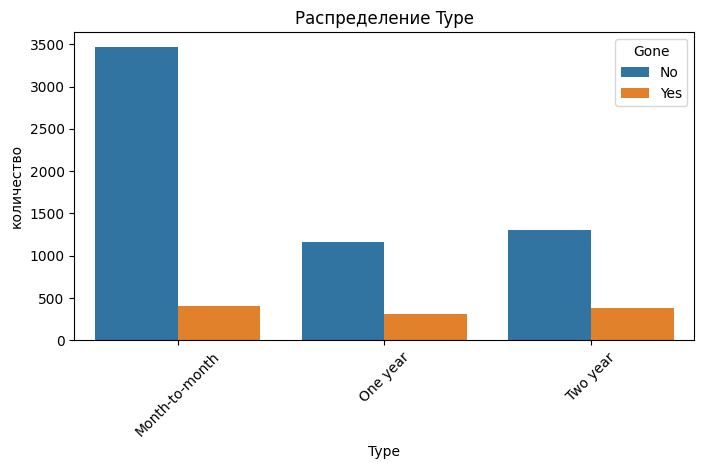

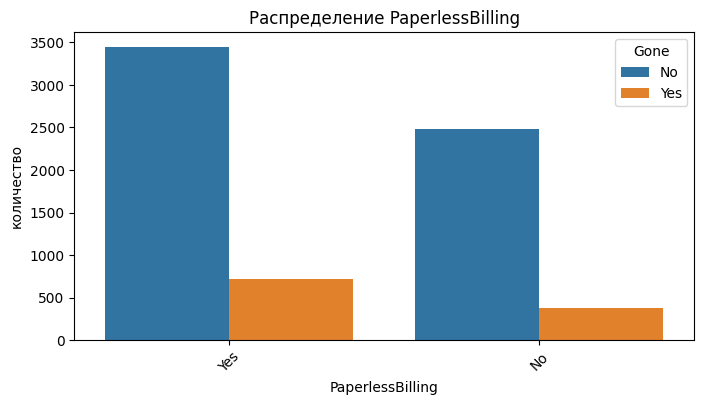

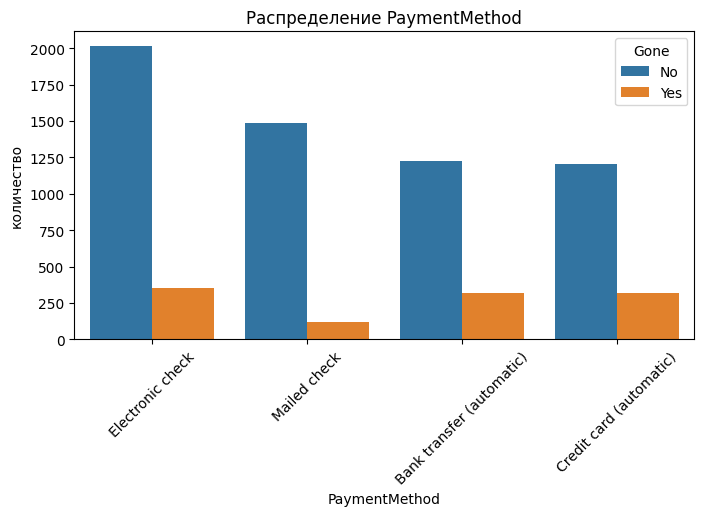

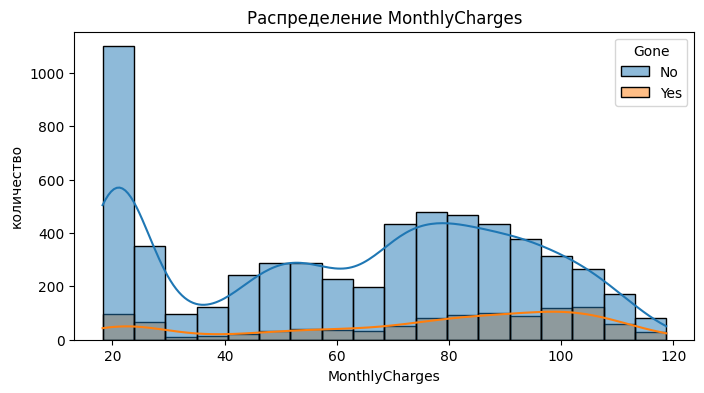

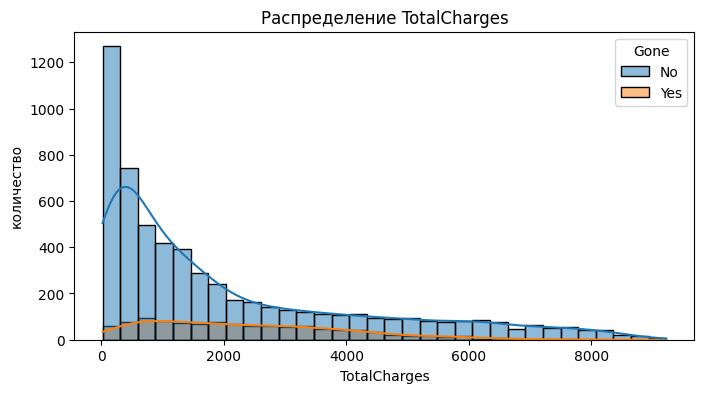

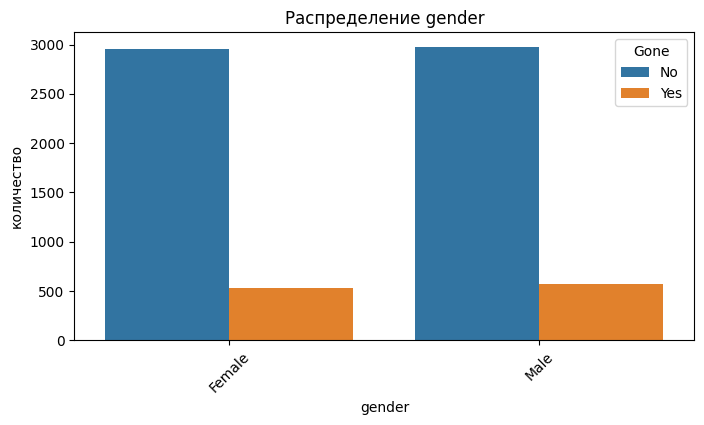

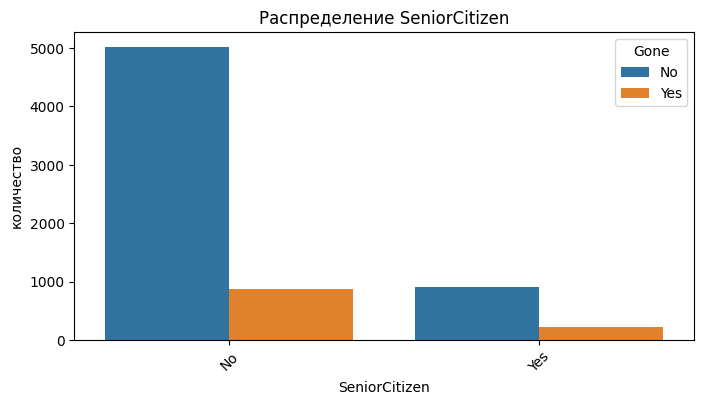

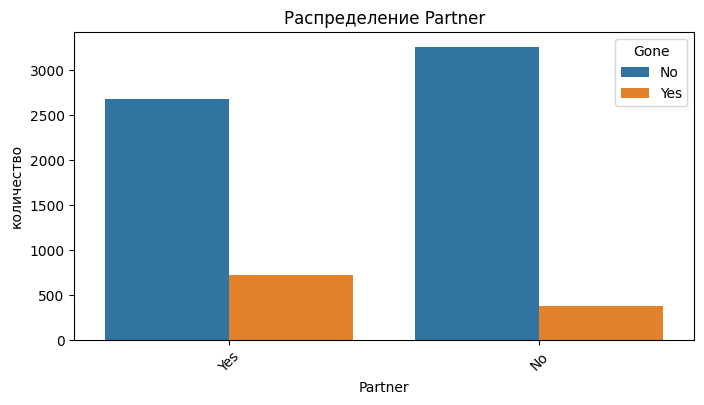

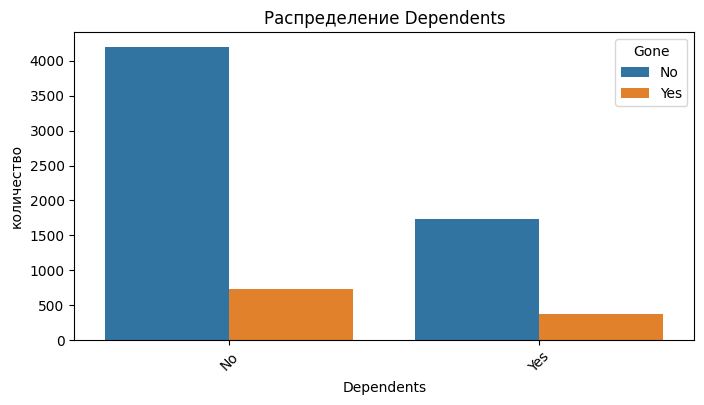

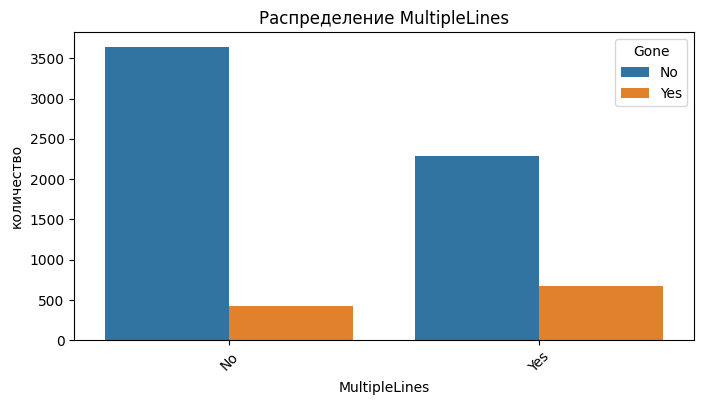

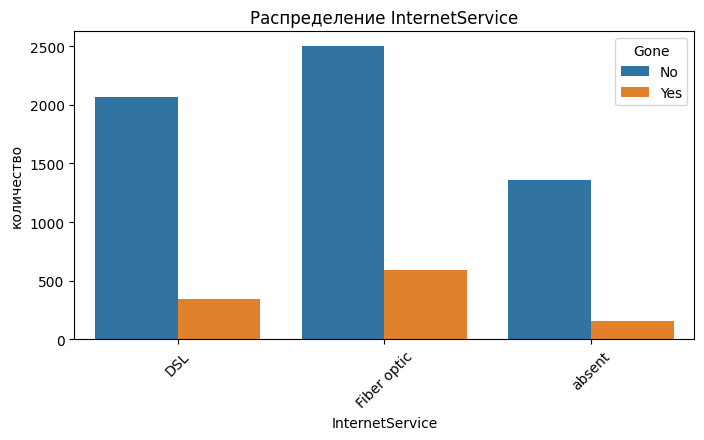

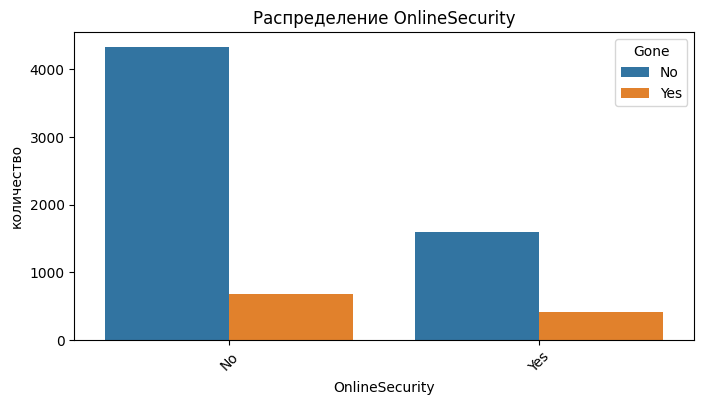

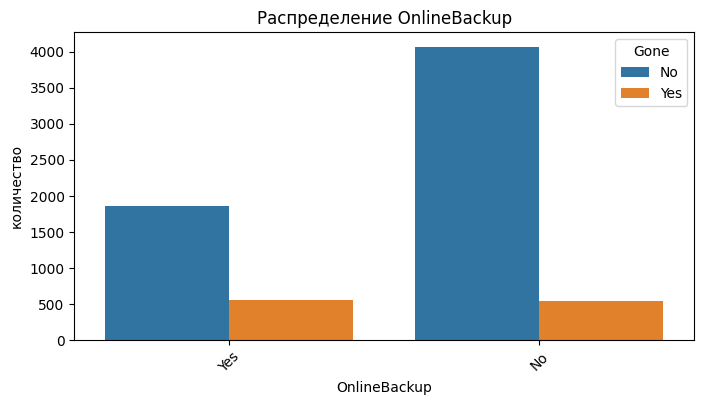

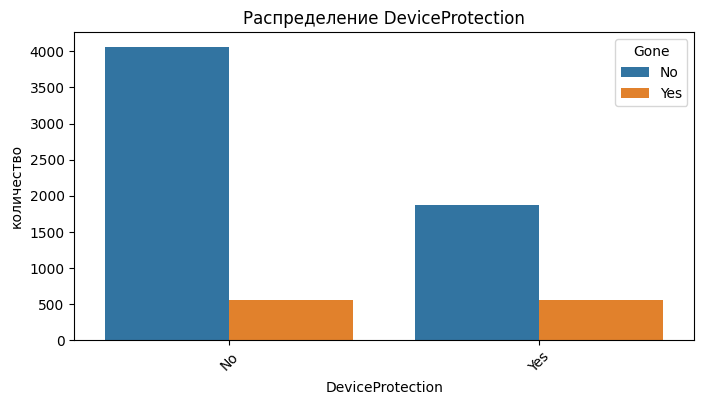

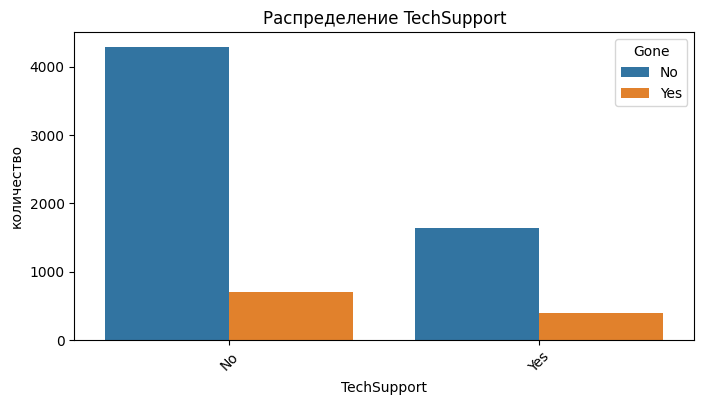

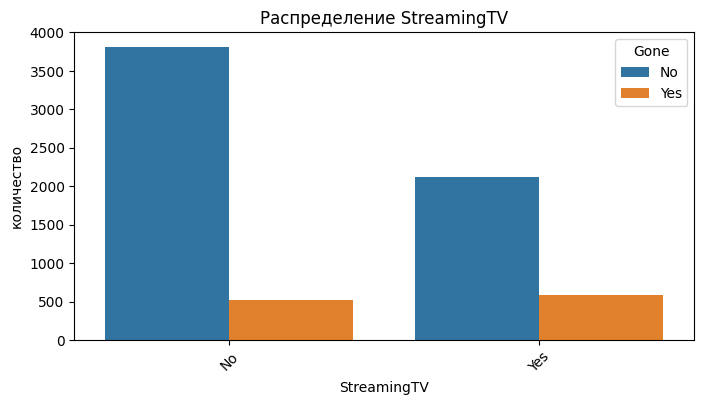

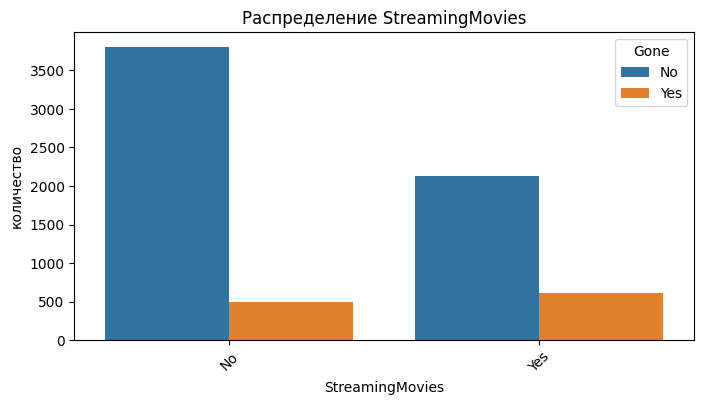

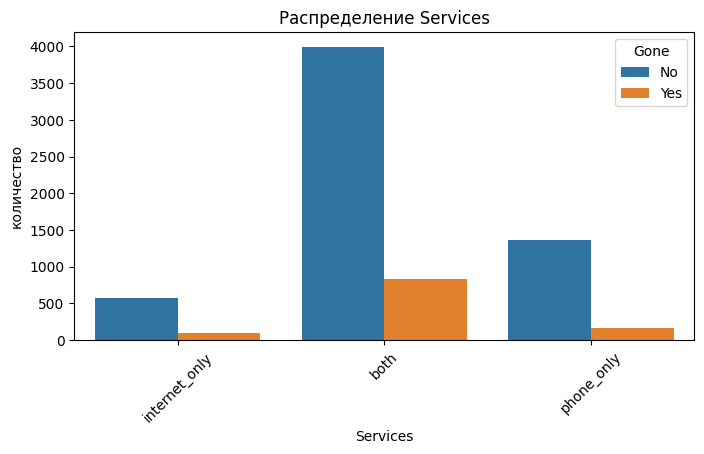

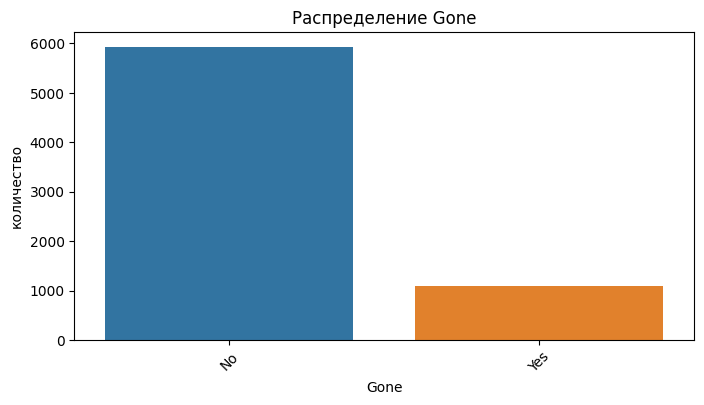

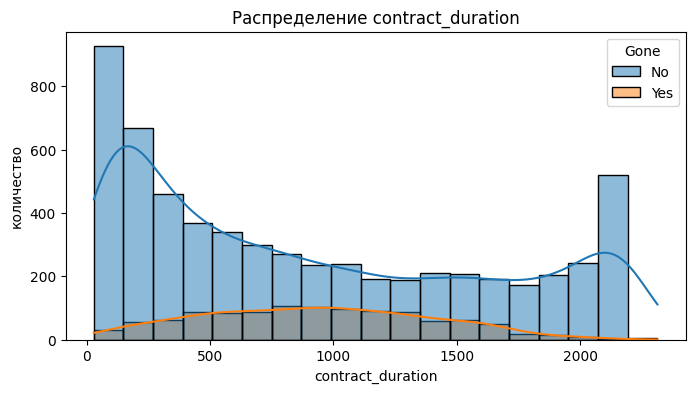

In [18]:
# Функция для построения визуализаций распределения признаков, с разделением на ушедших и не ушедших клиентов
def plot_column_distribution(data, column):
    plt.figure(figsize=(8, 4))
    
    if data[column].dtype == 'datetime64[ns]':
        pass
    elif data[column].dtype == 'object':
        # Если тип данных столбца - строка, строим столбчатую диаграмму
        sns.countplot(data=data, x=column, hue='Gone')
        plt.title(f'Распределение {column}')
        plt.xlabel(column)
        plt.ylabel('количество')
        plt.xticks(rotation=45)
    elif data[column].dtype == 'float64' or data[column].dtype == 'int64':
        # Если тип данных столбца - числовой, строим гистограмму
        sns.histplot(data=data, x=column, hue='Gone', kde=True)
        plt.title(f'Распределение {column}')
        plt.xlabel(column)
        plt.ylabel('количество')
    
    plt.show()

# Построим графики для каждого столбца датафрейма
for column in telecom_data.columns:
    plot_column_distribution(telecom_data, column)


**Таким образом,**  
- Среди ушедших клиентов среднемесячные платежи были выше, чем у среднего пользователя. Это может свидетельствовать о том, что высокие расходы на услуги связи могут быть одним из факторов, влияющих на решение клиента об уходе.

- Большинство клиентов, покинувших компанию, расторгли договор в течение первых 30 месяцев. Это может указывать на то, что важным периодом для удержания клиентов являются первые месяцы использования услуг.

- Большинство ушедших клиентов пользовались обоими типами услуг.  

- Ушедшие клиенты чаще всего имели партнера, что может указывать на необходимость разработки стратегии удержания для клиентов с партнерами.

**По графикам можно сформировать портрет уходящего клиента:**  
  
Это чаще всего абоненты с высокими ежемесячными платежами, использующие оба типа услуг, которые покидают компанию в течение первых месяцев использования услуг и обычно имеют партнера. Это дает нам понимание того, какие клиенты склонны к оттоку, и поможет выстроить стратегию удержания с учетом этих особенностей.

interval columns not set, guessing: ['MonthlyCharges', 'TotalCharges', 'contract_duration']


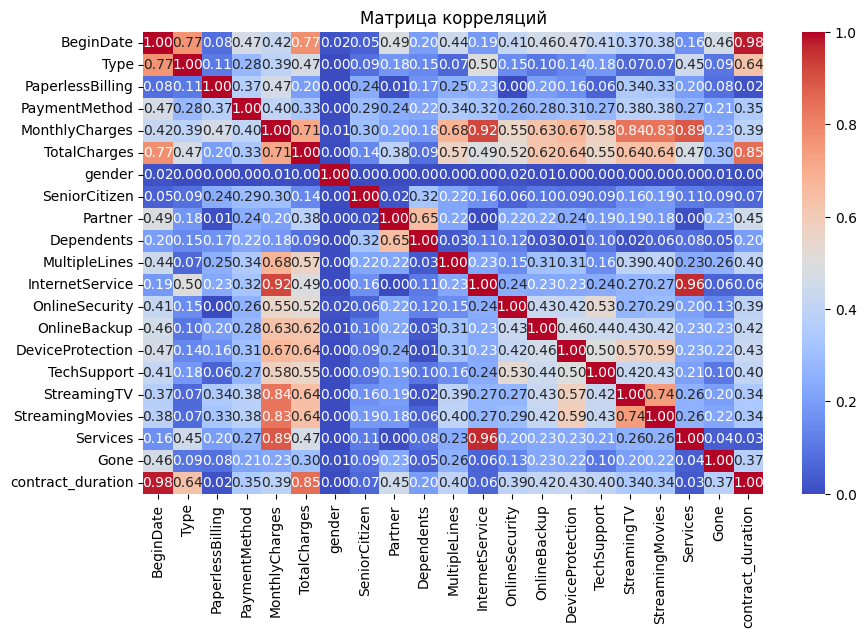

In [19]:
# Рассчет корреляции между всеми признаками с использованием phik
phik_matrix = telecom_data.phik_matrix()

# Построение тепловой карты корреляции
plt.figure(figsize=(10, 6))
sns.heatmap(phik_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Матрица корреляций')
plt.show()

**Таким образом,**  
- признаки, связанные с интернет-услугами, сильно коррелируют с признаками оплаты услуг
- гендер практически ни с чем не коррелирует
- BeginDate коррелирует с TоtalCharges и contract_duration, что логично

<a id='training'></a>
## Обучение моделей

Обучим три модели машинного обучения - логистическую регрессию, LGBMClassifier и XGBClassifier. В работе будем использовать пайплайны для кодирования и обучения с подбором гиперпараметров

In [20]:
# Разобьм данные на признаки и целевой признак
X = telecom_data.drop(columns=['Gone'])
y = telecom_data['Gone'].replace({'No': 0, 'Yes': 1})

C:\Users\rirke\AppData\Local\Temp\ipykernel_6096\2425423059.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y = telecom_data['Gone'].replace({'No': 0, 'Yes': 1})


Перед обучением важно проанализировать дисбаланс классов

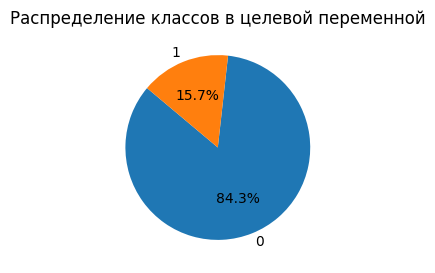

Распределение классов в целевой переменной:
Gone
0    5931
1    1101
Name: count, dtype: int64


In [21]:
# Проведём анализ на дисбаланс классов
class_distribution = y.value_counts()

# Визуализация распределения классов с помощью круговой диаграммы
plt.figure(figsize=(3, 3))
plt.pie(class_distribution, labels=class_distribution.index, autopct='%1.1f%%', startangle=140)
plt.title('Распределение классов в целевой переменной')
plt.show()

# Вывод распределения классов в виде таблицы
print("Распределение классов в целевой переменной:")
print(class_distribution)

- Класс 0 (не ушедшие клиенты) составляет около 84.3% от общего количества клиентов
- Класс 1 (ушедшие клиенты) составляет всего лишь около 15.7% от общего количества клиентов  

**Таким образом,** наблюдается дисбаланс классов, где класс 0 преобладает над классом 1. Модель, обученная на таких данных, может быть склонна к смещению в сторону прогнозирования класса 0 и не так хорошо предсказывать класс 1. Для борьбы с этим воспользумся средствами балансировки в моделях (class_weight) при обучении

In [22]:
# Разобьём данные

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=150324, stratify=y)

# Создание пайплайнов для предобработки данных
categorical_features = X.select_dtypes(include=['object']).columns
numerical_features = X.select_dtypes(include=['float64', 'int64']).columns

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(), categorical_features)
    ])

Результаты обучения будем выводить в виде таблицы

In [23]:
# Создадим таблицу с результатами обучения всех моделей
results = {'Model' : [], 'ROC-AUC score' : []}

In [24]:
# Пайплайн для логистической регрессии
logreg_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(class_weight='balanced'))
])

# Параметры для поиска по сетке
logreg_param_grid = {
    'classifier__C': [0.1, 1.0, 10.0]
}

# Подбор гиперпараметров и обучение модели
logreg_grid_search = GridSearchCV(logreg_pipeline, logreg_param_grid, cv=5, scoring='roc_auc')
logreg_grid_search.fit(X_train, y_train)

# Вывод результатов подбора гиперпараметров
print('Лучшие параметры:', logreg_grid_search.best_params_)
print('Лучшая метрика:', logreg_grid_search.best_score_)

Лучшие параметры: {'classifier__C': 0.1}
Лучшая метрика: 0.7792042147247685


In [25]:
results['Model'].append('LogisticRegression')
results['ROC-AUC score'].append(round(float(logreg_grid_search.best_score_), 3))

In [26]:
# Пайплайн для LightGBM
lgb_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', lgb.LGBMClassifier(class_weight='balanced'))
])

# Параметры для поиска по сетке
lgb_param_grid = {
    'classifier__n_estimators': [50, 100, 150],
    'classifier__learning_rate': [0.01, 0.05, 0.1],
    'classifier__max_depth': [3, 5, 7],
}

# Подбор гиперпараметров и обучение модели
lgb_grid_search = GridSearchCV(lgb_pipeline, lgb_param_grid, cv=5, scoring='roc_auc')
lgb_grid_search.fit(X_train, y_train)

# Вывод результатов подбора гиперпараметров
print('Лучшие параметры:', lgb_grid_search.best_params_)
print('Лучшая метрика:', lgb_grid_search.best_score_)

[LightGBM] [Info] Number of positive: 661, number of negative: 3558
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001264 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 749
[LightGBM] [Info] Number of data points in the train set: 4219, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Info] Number of positive: 661, number of negative: 3558
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000379 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 745
[LightGBM] [Info] Number of data points in the train set: 4219, number of used features: 40
[LightGBM] [Info] [binary:Boos

In [27]:
results['Model'].append('LGBMClassifier')
results['ROC-AUC score'].append(round(float(lgb_grid_search.best_score_), 3))

In [28]:
# Пайплайн для XGBoost
xgb_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', xgb.XGBClassifier(class_weight='balanced'))
])

# Параметры для поиска по сетке
xgb_param_grid = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__learning_rate': [0.01, 0.05, 0.1],
    'classifier__max_depth': [3, 5, 7]
}

# Подбор гиперпараметров и обучение модели
xgb_grid_search = GridSearchCV(xgb_pipeline, xgb_param_grid, cv=5, scoring='roc_auc')
xgb_grid_search.fit(X_train, y_train)

# Вывод результатов подбора гиперпараметров
print('Лучшие параметры:', xgb_grid_search.best_params_)
print('Лучшая метрика:', xgb_grid_search.best_score_)

c:\Users\rirke\Desktop\CS_practice\python\финальный проект практикум(телеком)\env\Lib\site-packages\xgboost\core.py:160: UserWarning: [19:36:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\rirke\Desktop\CS_practice\python\финальный проект практикум(телеком)\env\Lib\site-packages\xgboost\core.py:160: UserWarning: [19:36:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\rirke\Desktop\CS_practice\python\финальный проект практикум(телеком)\env\Lib\site-packages\xgboost\core.py:160: UserWarning: [19:36:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-

Лучшие параметры: {'classifier__learning_rate': 0.1, 'classifier__max_depth': 5, 'classifier__n_estimators': 300}
Лучшая метрика: 0.8915911252967925


In [29]:
results['Model'].append('XGBClassifier')
results['ROC-AUC score'].append(round(float(xgb_grid_search.best_score_), 3))

In [30]:
# Выведем результаты в виде таблицы
results = pd.DataFrame(results)
results

,Model,ROC-AUC score
0,LogisticRegression,0.779
1,LGBMClassifier,0.868
2,XGBClassifier,0.892


**Лучшей моделью оказалась XGBClassifier** c AUC-ROC=0.89 при параметрах {'classifier__learning_rate': 0.1, 'classifier__max_depth': 5, 'classifier__n_estimators': 300} на тренировочных данных, протестируем её на тестовых данных

<a id='testing'></a>
## Тестирование

Проведём проверку лучшей модели на тестовых данных

In [31]:
# Пайплайн для XGBClassifier
xgb_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', xgb.XGBClassifier(learning_rate=0.1, max_depth=5, n_estimators=300))
])

# Обучение модели
xgb_pipeline.fit(X_train, y_train)

# Предсказания на тестовой выборке
xgb_pred_proba = xgb_pipeline.predict_proba(X_test)[:, 1]

# Вычисление метрики AUC ROC
xgb_auc_roc = roc_auc_score(y_test, xgb_pred_proba)
print("AUC ROC:", xgb_auc_roc)

# Дополнительно вычислим метрику accuracy
xgb_pred = xgb_pipeline.predict(X_test)
xgb_accuracy = accuracy_score(y_test, xgb_pred)

print("Accuracy:", xgb_accuracy)

AUC ROC: 0.8972230736222644
Accuracy: 0.888509670079636


**Можно увидеть, что** были достигнуты хорошие показатели метрик

<a id='results'></a>
## Анализ лучшей модели

Проанализируем результаты предсказаний с помощью confusion matrix и графика ROC-кривой, проанализируем важность признаков в итоговой модели

In [32]:
# Построение confusion matrix
conf_matrix = confusion_matrix(y_test, xgb_pred)
print("Confusion Matrix:")
print(conf_matrix)


Confusion Matrix:
[[1442   41]
 [ 155  120]]


Из этого анализа видно, что модель достаточно хорошо справляется с предсказанием того, что клиенты останутся (TN) и того, что они уйдут (TP). Стоит обратить внимание на ложные отрицательные значения (FN), это упущеные ушедшие клиенты.  
Однако значение (FP) достаточно низкое, что позволяет избежать лишних расходов на ложно-положительных клиентов.


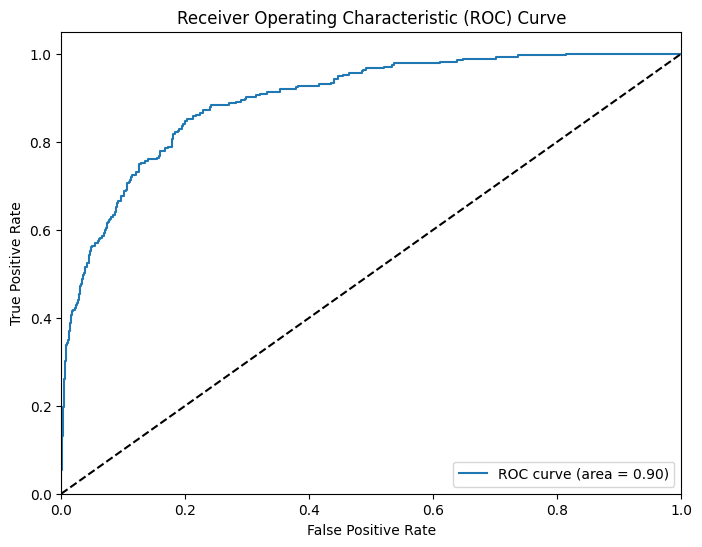

In [33]:
# Вычисление ROC кривой
fpr, tpr, thresholds = roc_curve(y_test, xgb_pred_proba)

# Построение ROC кривой
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % xgb_auc_roc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

График ROC-AUC позволяет визуализировать производительность модели при различных пороговых значениях для классификации. Чем ближе кривая к верхнему левому углу графика, тем лучше производительность модели. Анализируя кривую, можно сделать вывод о том, что модель обладает хорошей способностью разделения классов, так как кривая стремится к верхнему левому углу, и площадь под кривой (AUC) составляет 0.9

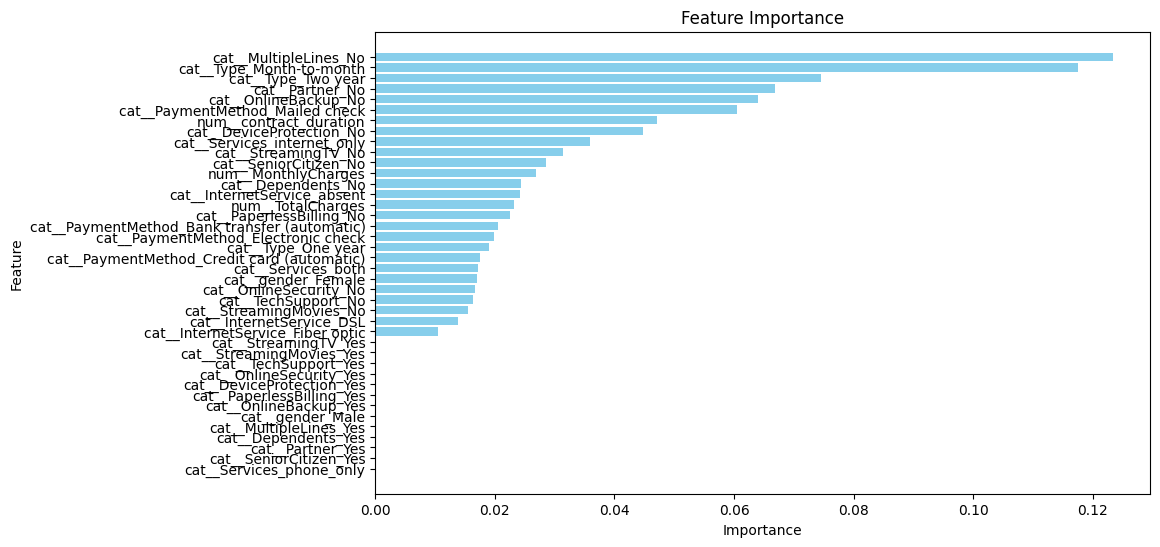

In [34]:
# Проанализируем важность признаков

feature_importance = xgb_pipeline.named_steps['classifier'].feature_importances_

# Получение имен признаков
feature_names = xgb_pipeline.named_steps['preprocessor'].get_feature_names_out()

# Создание DataFrame с важностью признаков
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})

# Сортировка по важности
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Создание графика
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.gca().invert_yaxis()  # Инвертируем ось y для удобства чтения
plt.show()


**На основе графика важности признаков можно сделать следующие выводы:**  

- Самым важным признаком оказалось отсутствие нескольких линий связи (MultipleLines_No). Это указывает на то, что клиенты, не использующие несколько линий связи, имеют более высокую вероятность ухода от провайдера.

- Затем следует тип контракта "Month-to-month" (Ежемесячный контракт). Это говорит о том, что клиенты с таким типом контракта более склонны к уходу от провайдера, что логично из-за их гибкости и отсутствия долгосрочных обязательств.

- Важным признаком также является тип контракта "Two year" (Двухгодичный контракт), что может указывать на более высокую лояльность клиентов, заключивших долгосрочный контракт.

- Среди методов оплаты наибольшее влияние оказывает "Mailed check" (Чек по почте), что может свидетельствовать о менее активном использовании онлайн-сервисов и, возможно, о более низкой лояльности таких клиентов.

- Другие важные признаки включают наличие услуг интернета, тип контракта "One year" (Одногодичный контракт), наличие партнера и иждевенцев, а также ежемесячные затраты клиента. Все эти факторы могут оказывать существенное влияние на решение клиента об уходе или оставании с провайдером.

<a id='conclusion'></a>
## Вывод


**Обзор работы по анализу оттока клиентов:**  

- Предобработка данных:

    - Данные о клиентах телекоммуникационной компании были загружены и прошли предварительный анализ.
Предобработка данных включала в себя заполнение пропусков, генерацию новых признаков - среди которых длительность контракта, тип услуг, используемых клиентом, факт ухода клиента, преобразование типов
- Исследовательский анализ данных (EDA):

    - В ходе EDA были созданы визуализации распределений для всех признаков, включая визуализацию корреляций между признаками.
- Обучение моделей:

    - Для прогнозирования оттока клиентов были обучены несколько моделей классификации, используя встроенные методы балансировки классов, включая LightGBM, XGBoost и логистическую регрессию.
    
- Оценка качества моделей:

Для оценки качества моделей использовалась метрика AUC-ROC.  Были получены следующие результаты:
| Model              | ROC-AUC score |
|--------------------|---------------|
| LogisticRegression | 0.758         |
| LGBMClassifier     | 0.863         |
| XGBClassifier      | 0.891         |  

Лучшей моделью, выбранной для дальнейшего использования, оказалась модель XGBoost.  
- Результаты лучшей модели:

Модель XGBoost показала высокие показатели качества с AUC-ROC около **0.897** на тестовом наборе данных.
Точность модели, измеренная по дополнительной метрике accuracy, составила около 0.889  
Гиперпараметры лучшей модели:
| Parameter                     | Value |
|-------------------------------|-------|
| classifier__learning_rate     | 0.1   |
| classifier__max_depth         | 5     |
| classifier__n_estimators      | 300   |



**Рекомендации для бизнеса:**

- Активно использовать разработанную модель XGBoost для прогнозирования оттока клиентов и принятия мер по их удержанию.
- Разработать программу лояльности и предложить персонализированные акции и скидки для клиентов с высоким риском ухода.
- Улучшить уровень обслуживания клиентов, чтобы повысить их удовлетворенность и снизить отток.